In [9]:
# %pip install pandas numpy
# %pip install scikit-learn
# %pip install RDKit
# %pip install matplotlib networkx
# %pip install tqdm 
# %pip install rdkit
# %pip install xgboost
# %pip install sklearn

# 思路记录
## 

# 1.

In [10]:
import pandas as pd
import numpy as np
tox_data = pd.read_csv('../data/tox21.csv')
tox_data.head(2)

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O


In [11]:
# Step 1: 识别标签列（12个毒性相关的列）
label_cols = [
    'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER',
    'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5',
    'SR-HSE', 'SR-MMP', 'SR-p53'
]

# Step 2: 统计标签完全缺失和完全非缺失的样本数量
total_samples = tox_data.shape[0]
all_nan_labels = tox_data[label_cols].isna().all(axis=1).sum()
no_nan_labels = tox_data[label_cols].notna().all(axis=1).sum()
partial_nan_labels = total_samples - all_nan_labels - no_nan_labels

{
    "总样本数": total_samples,
    "标签全缺失样本数": int(all_nan_labels),
    "标签无缺失样本数": int(no_nan_labels),
    "标签部分缺失样本数": int(partial_nan_labels)
}
# 统计每个标签缺失值的数量
missing_counts_per_label = tox_data[label_cols].isna().sum().sort_values(ascending=False)

missing_counts_per_label

## 缺失样本设置为0（不具备该特征）
# 将所有标签列中的缺失值填充为 0，表示“无该毒性特征”
tox_data[label_cols] = tox_data[label_cols].fillna(0)

# 检查是否填充成功（应返回 0）
remaining_missing = tox_data[label_cols].isna().sum().sum()
int(remaining_missing)


0

## 📍 Step 2：特征工程（分子指纹提取）
### 使用 RDKit 提取每个 SMILES 的 ECFP4指纹：

- radius=2，生成 ECFP4
- 设置固定向量长度，如 nBits=1024
- 每个分子将转换为一个 0/1的稀疏向量

### 最终特征矩阵形状：(num_samples, 1024)

In [12]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from tqdm import tqdm

# 定义 SMILES → ECFP4 指纹向量函数
def smiles_to_ecfp4(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)  # 用RDKit将SMILES转成分子对象（Mol）
    if mol is None:
        return np.zeros(nBits, dtype=int)  # 无效的SMILES返回全0向量

    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)  
    # 生成ECFP4分子指纹，radius=2表示ECFP4，nBits表示指纹长度（如1024位）

    arr = np.zeros((nBits,), dtype=int)  # 先创建一个全0的一维数组
    DataStructs.ConvertToNumpyArray(fp, arr)  # 把指纹位向量（BitVect）复制到numpy数组中
    return arr  # 返回一个 numpy 的 0/1 向量，长度为 nBits

# 应用处理
tqdm.pandas()
X_fp = np.vstack(tox_data['smiles'].progress_apply(smiles_to_ecfp4))

# 标签矩阵
y = tox_data[label_cols].values

# 输出结果形状
print("特征矩阵 X_fp.shape =", X_fp.shape)
print("标签矩阵 y.shape =", y.shape)


  0%|          | 0/8006 [00:00<?, ?it/s][16:32:57] DEPRECATION WARNING: please use MorganGenerator
[16:32:57] DEPRECATION WARNING: please use MorganGenerator
[16:32:57] DEPRECATION WARNING: please use MorganGenerator
[16:32:57] DEPRECATION WARNING: please use MorganGenerator
[16:32:57] DEPRECATION WARNING: please use MorganGenerator
[16:32:57] DEPRECATION WARNING: please use MorganGenerator
[16:32:57] DEPRECATION WARNING: please use MorganGenerator
[16:32:57] DEPRECATION WARNING: please use MorganGenerator
[16:32:57] DEPRECATION WARNING: please use MorganGenerator
[16:32:57] DEPRECATION WARNING: please use MorganGenerator
[16:32:57] DEPRECATION WARNING: please use MorganGenerator
[16:32:57] DEPRECATION WARNING: please use MorganGenerator
[16:32:57] DEPRECATION WARNING: please use MorganGenerator
[16:32:57] DEPRECATION WARNING: please use MorganGenerator
[16:32:57] DEPRECATION WARNING: please use MorganGenerator
[16:32:57] DEPRECATION WARNING: please use MorganGenerator
[16:32:57] DEPRE

特征矩阵 X_fp.shape = (8006, 1024)
标签矩阵 y.shape = (8006, 12)


## 📍 Step 3：模型选择与训练
### 模型类型：多标签分类（Multi-label classification）
- 每个样本可能属于多个类别（例如第1个分子同时毒性激活AR和ER）

### 推荐方式：Binary Relevance策略 + XGBoost（Gradient Boosting）
- 将问题分成12个独立的二分类任务
- 为每个标签训练一个独立的 XGBoost 模型


In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score


# 准备数据
X = X_fp
y = tox_data[label_cols].values
label_names = label_cols

# 存储训练结果
models = {}
reports = {}
auc_scores = {}

# 遍历每个标签
for i, label in enumerate(label_names):
    # print(f"\n🔍 Training model for label: {label}")
    
    # 拆分训练集和测试集（保持每个标签的比例）
    X_train, X_test, y_train, y_test = train_test_split(
        X, y[:, i],
        test_size=0.2,
        random_state=42,
        stratify=y[:, i]  # 使0/1比例相对均衡
    )
    
    # 初始化模型
    model = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        # use_label_encoder=False,
        eval_metric='logloss'
    )
    
    # 模型训练
    model.fit(X_train, y_train)
    
    # 模型预测
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # 保存模型与评估结果
    models[label] = model
    reports[label] = classification_report(y_test, y_pred, output_dict=True)
    auc_scores[label] = roc_auc_score(y_test, y_proba)
    
    # print(f"✅ Done. Accuracy: {accuracy_score(y_test, y_pred):.4f}, AUC: {auc_scores[label]:.4f}")


In [14]:
# 将 auc_scores 字典转换成 DataFrame
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])

# 按照 AUC 值从高到低排序
auc_df_sorted = auc_df.sort_values(by='AUC', ascending=False)

# 打印结果
print("📊 每个毒性标签的 AUC 排序表：")
display(auc_df_sorted)

📊 每个毒性标签的 AUC 排序表：


,AUC
NR-AhR,0.868885
SR-MMP,0.840447
NR-AR,0.812275
SR-ATAD5,0.810054
NR-Aromatase,0.809656
NR-ER-LBD,0.792385
SR-p53,0.790130
NR-AR-LBD,0.768025
SR-HSE,0.761658
SR-ARE,0.726751


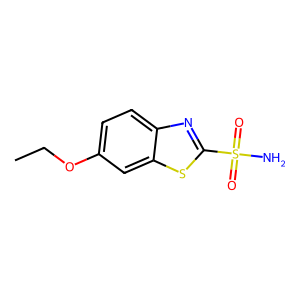

In [15]:
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
import matplotlib.pyplot as plt

smiles_sample = tox_data['smiles'][0].strip()
mol = Chem.MolFromSmiles(smiles_sample)
Draw.MolToImage(mol)


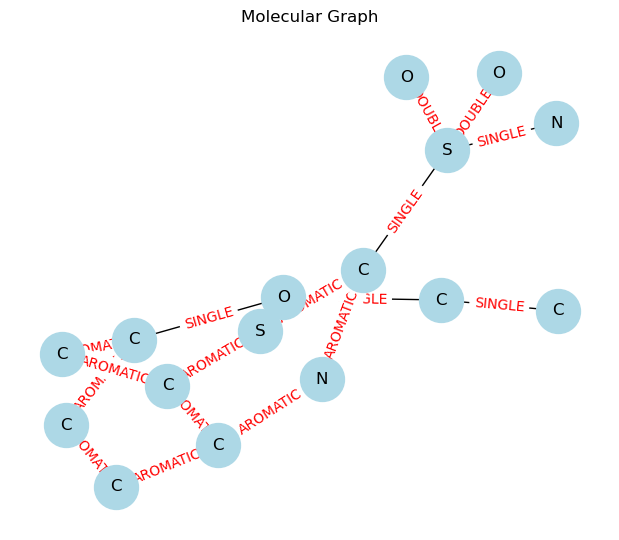

In [16]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    G = nx.Graph()
    
    # 添加原子节点
    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
        G.add_node(idx, label=atom.GetSymbol())
    
    # 添加键（边）
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        bond_type = str(bond.GetBondType())
        G.add_edge(a1, a2, label=bond_type)
    
    return G, mol

def draw_graph(G):
    pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')

    plt.figure(figsize=(6, 5))
    nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', node_size=1000, font_size=12)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title("Molecular Graph")
    plt.axis('off')
    plt.show()
    
    
G, mol = smiles_to_graph(smiles_sample)
draw_graph(G)